<a href="https://colab.research.google.com/github/arkothiwala/Analytics-Vidhya/blob/master/AV_GoD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the dataset



In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import torch
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1zRzgwnzMs52MN674v6TFDOMrKi1jg6dN' #File ID for the required Trainingdata
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train-ship classification.zip')

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('train-ship classification.zip', 'r')
zip_ref.extractall('data')
zip_ref.close()



---

Downloaded the data and unzipped

---



### Importing libraries and reading the data

# Roadmap:


1.   Load data


> 1.1 Determine missing data<br>
> 1.2 Add raw image data column<br>
> 1.3 Determine shapes of images<br>


2.   Process images



> 2.1 add padding<br>
> 2.2 add/remove dimentions







# 1. Load Data

In [4]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #To plot images
import keras
import tensorflow as tf

Using TensorFlow backend.


In [5]:
train_csv = pd.read_csv('./data/train.csv')
train_csv.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


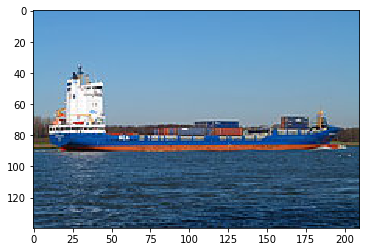

In [6]:
# Let's look at the image
img=mpimg.imread('./data/images/2823080.jpg')
imgplot = plt.imshow(img)

In [7]:
# Lets us see category column of the data
train_csv.category.describe()

count    6252.000000
mean        2.657550
std         1.528998
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         5.000000
Name: category, dtype: float64

In [18]:
# Null check
train_csv.isnull().sum()

image       0
category    0
raw         0
dtype: int64

## 1.2 Add raw image data column

In [0]:
base_url = './data/images/'
# Create a column to represent raw image data
train_csv['raw'] = [mpimg.imread(base_url+image_url) for image_url in train_csv.image]

## 1.3 Image Processing



*   Some of the images can be of gray scale having just two channels
*   Such images needs to be converted to 3 channels (RGB values same as in single channel)



In [0]:
dim_dict = {}
for i in range(len(train_csv)):
  dimension = len(train_csv.raw.iloc[i].shape)
  if dimension in dim_dict:
    dim_dict[dimension] += 1
  else:
    dim_dict[dimension] = 1

In [14]:
dim_dict

{2: 104, 3: 6148}

As it can be noticed, some images are having two channels only. Which needs to be converted in to three channels

In [15]:
for i in range(len(train_csv.raw)):
  if(len(train_csv.raw.iloc[i].shape)==2):
    train_csv.raw.iloc[i] = np.stack((train_csv.raw.iloc[i],)*3, axis=-1)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### 3. Splitting train-test data

Just splitting data in to training and test set

In [0]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(train_csv.raw, train_csv.category, test_size=0.3)

In [0]:
del train_X, test_X, train_Y, test_Y

### 3.3 Encoding category to One-Hot encoding

In [60]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories='auto')
enc.fit(np.array(train_csv.category).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [0]:
train_csv['encoded_category'] = enc.transform(np.array(train_csv.category).reshape(-1,1)).toarray().tolist()
train_csv.encoded_category.head()

Now we have encoded category list

# 2. Image preprocessing

Images in the dataset are of different size <br>
In order to feed it to the network, we need to make them to the same size <br>
Hence, let find out maximum dimensions of the image and pad smaller images with the same

#### Doubt: Should I first do augmentation then padding or viceversa ?

### Calculating maximum image size:

In [0]:
max_width = 0
max_height = 0
for image in train_csv.raw:
  height, width, depth = image.shape
  max_width = max(width, max_width)
  max_height = max(height, max_height)

In [74]:
max_width

210

In [75]:
max_height

158

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
count = 0
for image in train_csv.raw:
  if(len(image.shape)==2):
    plt.imshow(np.stack((image,)*3, axis=-1))
    plt.show()
    count += 1

It shows that 104 images are 2D

In [0]:
count

0

In [0]:
count/len(train_csv)

0.016634676903390915